In [32]:
import numpy as np
import scipy as sp
import scipy.sparse as ss
import seaborn as sns
import matplotlib.pyplot as plt

from par2vec.common import *

### Load Reuters

In [40]:
# Load tokenized reuters
topic2id = np.load('data/reuters/reuters_topic2id.npy').item(0)
id2topic = np.load('data/reuters/reuters_id2topic.npy').item(0)
topics = list(np.load('data/reuters/reuters_topics.npy'))

word2id = np.load('data/reuters/reuters_word2id.npy').item(0)
id2word = np.load('data/reuters/reuters_id2word.npy').item(0)
tokenized = list(np.load('data/reuters/reuters_tokenized.npy'))

### Compute document graphs and essentials

In [34]:
# Create graphs for N documents
N=100000
max_w=13

counts = np.zeros((N, max_w))
entropies = []
for i, (A_o, A_i, _, _) in enumerate(get_lapl(tokenized[:N], word2id)):
    if i % 5000 == 0:
        print('{}/{}'.format(i, N))
        
    # Graph
    A = (A_o + A_i).data
    
    # Weight counts
    bincount = np.bincount(A.astype(int))
    for j in range(min(len(bincount), max_w)):
        counts[i, j] = bincount[j]
        
    # Entropies
    entropies.append(sp.stats.entropy((A_o + A_i).data))
    

# Parse data
x = np.arange(1, max_w)
y_mean = np.mean(counts[:,1:], axis=0)
y_std = np.std(counts[:,1:], axis=0)

0/100000
5000/100000


KeyboardInterrupt: 

### Plot distribution of non-zero graph weights

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Distribution of non-zero graph weights')
plt.xlabel('Weight')
plt.ylabel('Average Count')
plt.yscale('log')
plt.errorbar(x, y_mean, yerr=y_std)
plt.savefig('plots/dist_nonzero_graph_weights.png')
plt.show()

### Plot distribution graph entropies 

In [35]:
plt.figure(figsize=(7,5))
plt.title('Distribution of graph entropies')
plt.xlabel('Entropy')
plt.ylabel('Occurence')
sns.distplot(ents, bins=50)
plt.savefig('plots/dist_graph_entropies.png')
plt.show()

NameError: name 'ents' is not defined

### Plot distribution of topics

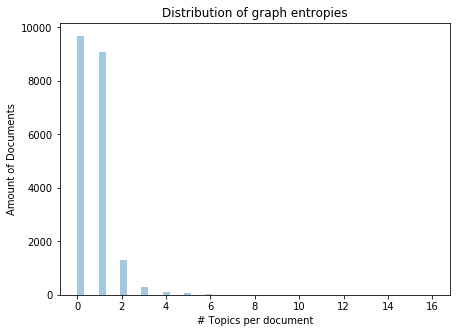

In [36]:
topic_count = [len(x) for x in topics]
plt.xlabel('# Topics per document')
plt.ylabel('Amount of Documents')
sns.distplot(topic_count, kde=False, )
plt.savefig('plots/dist_topics_over_docs.png')
plt.show()

### Plot class imbalance

Counts per class: [2390   61    4   54    1  116    3   72    2    1    1   75    5    6  142
   77    3  247    1    2   62    3    1  111    4  597    1    3    1  215
   15 3729    3    2   27   64  163  133  613   10    2   25    1   27   19
   18    7  493    7   65   65    7   75    8   35   17    1    2    2    3
  111   16   49  767  186    7  128   11    3    4   14  187   29    3   42
    2    1   40   12    4    4    6    6    3    1    8   34    1   82   27
   66    1   48    1    2    3    3  285   37    1   35   25   25  115   21
   32  183    2    8   15    4   15   32  538  132  298    2   32   68   44]


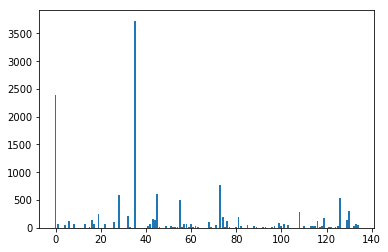

In [37]:
flat_topics = [item for sublist in topics for item in sublist]
topic_i, topic_count = np.unique(flat_topics, return_counts=True)
print('Counts per class:', y)
plt.bar(x, y)
plt.savefig('plots/dist_topic_counts.png')
plt.show()

In [50]:
id2topic[x[np.argmax(y)]]

'earn'